In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *

In [3]:
from bnbsl import *

In [4]:
SEASON = '21'
set_seed(int(SEASON))

## Data preparation

In [5]:
path = Path()
path_data = Path('data')

In [6]:
df = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])

In [7]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2']
df = df[(df.Div.isin(div)) & (df.Season >= 18) & (df.Season <= 21)]

# Drop NA corner
df = df.dropna().reset_index(drop=True)

In [8]:
add_datepart(df, 'Date');

In [9]:
# Time-weighted
df['weight'] = np.exp(-(df.Elapsed.max() - df.Elapsed) / (3600*24*365) / df.Year.nunique())
df['weight'] = df['weight'] / df['weight'].mean()

In [10]:
procs = [Categorify, FillMissing, Normalize]

In [11]:
valid_idx = list(df.query('Season == 21').index)

In [12]:
splitter = IndexSplitter(valid_idx)
splits = splitter(range_of(df))

In [13]:
splits

((#12557) [0,1,2,3,4,5,6,7,8,9...],
 (#3527) [918,919,920,921,922,923,924,925,926,927...])

In [14]:
y_names = ['HC', 'AC']
cat_names = ['Div', 'HomeTeam', 'AwayTeam']
# cont_names = list(df.columns[df.columns.str.contains('Avg')])

In [15]:
cont_names = [
    'HSLast5Avg', 
    'HCLast5Avg', 
    'ASLast5Avg', 
    'ACLast5Avg', 
    'HomeSForLast5Avg', 
    # 'HomeCForLast5Avg', 
    'AwaySForLast5Avg', 
    # 'AwayCForLast5Avg',
    'HomeSAgainstLast5Avg', 
    # 'HomeCAgainstLast5Avg', 
    'AwaySAgainstLast5Avg', 
    # 'AwayCAgainstLast5Avg',
]

In [16]:
y_block = RegressionBlock(n_out=2)

In [17]:
df.sample(10)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,weight
13785,SP1,Villarreal,Valladolid,2.0,0.0,11.0,11.0,5.0,1.0,6.0,...,0,307,False,False,False,False,False,False,1.604275e+09,1.052213
7387,E2,Cambridge,Burton,3.0,0.0,7.0,19.0,2.0,9.0,8.0,...,5,233,False,False,False,False,False,False,1.629504e+09,1.234784
15705,SP2,Vallecano,Oviedo,4.0,1.0,11.0,8.0,3.0,3.0,4.0,...,3,140,False,False,False,False,False,False,1.621469e+09,1.173437
11416,I1,Juventus,Bologna,2.0,0.0,22.0,12.0,12.0,3.0,7.0,...,6,24,False,False,False,False,False,False,1.611446e+09,1.101172
2481,E0,Cardiff,Man United,1.0,5.0,9.0,17.0,3.0,9.0,4.0,...,5,356,False,False,False,False,False,False,1.545437e+09,0.724513
518,D1,RB Leipzig,Leverkusen,1.0,1.0,9.0,14.0,2.0,6.0,8.0,...,6,61,False,True,False,False,False,False,1.583021e+09,0.919524
12783,I2,Como,Parma,1.0,1.0,13.0,12.0,5.0,6.0,5.0,...,6,332,False,False,False,False,False,False,1.638058e+09,1.303616
7922,F1,Guingamp,Strasbourg,1.0,1.0,10.0,12.0,4.0,5.0,6.0,...,5,300,False,False,False,False,False,False,1.540598e+09,0.702619
16031,SP2,Las Palmas,Lugo,2.0,2.0,12.0,7.0,4.0,3.0,7.0,...,5,57,False,False,False,False,False,False,1.645834e+09,1.369516
1550,D2,Dresden,Bielefeld,0.0,1.0,5.0,14.0,1.0,7.0,0.0,...,5,299,False,False,False,False,False,False,1.572048e+09,0.857711


In [18]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [19]:
to.cat_names, to.cont_names

((#3) ['Div','HomeTeam','AwayTeam'],
 (#8) ['HSLast5Avg','HCLast5Avg','ASLast5Avg','ACLast5Avg','HomeSForLast5Avg','AwaySForLast5Avg','HomeSAgainstLast5Avg','AwaySAgainstLast5Avg'])

In [20]:
display_df(to.xs.iloc[-2:])

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
16082,11,156,188,-0.780917,0.189180,-0.169676,-0.858292,1.391442,-0.108810,0.480398,1.516797
16083,11,123,129,-0.495240,-0.222606,-1.117650,-1.615405,0.484972,-0.482369,0.187601,-0.259846


### To other packages (e.g. Scikit-learn, LightGBM, XGBoost)

In [21]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [22]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

In [23]:
X_train.shape, y_train.shape

((12557, 11), (12557, 2))

In [24]:
X_test.shape, y_test.shape

((3527, 11), (3527, 2))

## LightGBM

In [25]:
fit_params = {'feature_name':list(X_test.columns), 'categorical_feature':cat_names}

In [26]:
m_lgbm = MultiOutputRegressor(LGBMRegressor(objective='poisson', n_estimators=100, n_jobs=-1, reg_lambda=1.0))
m_lgbm.fit(X_train, y_train, **fit_params)

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


MultiOutputRegressor(estimator=LGBMRegressor(objective='poisson',
                                             reg_lambda=1.0))

In [27]:
import lightgbm as lgbm

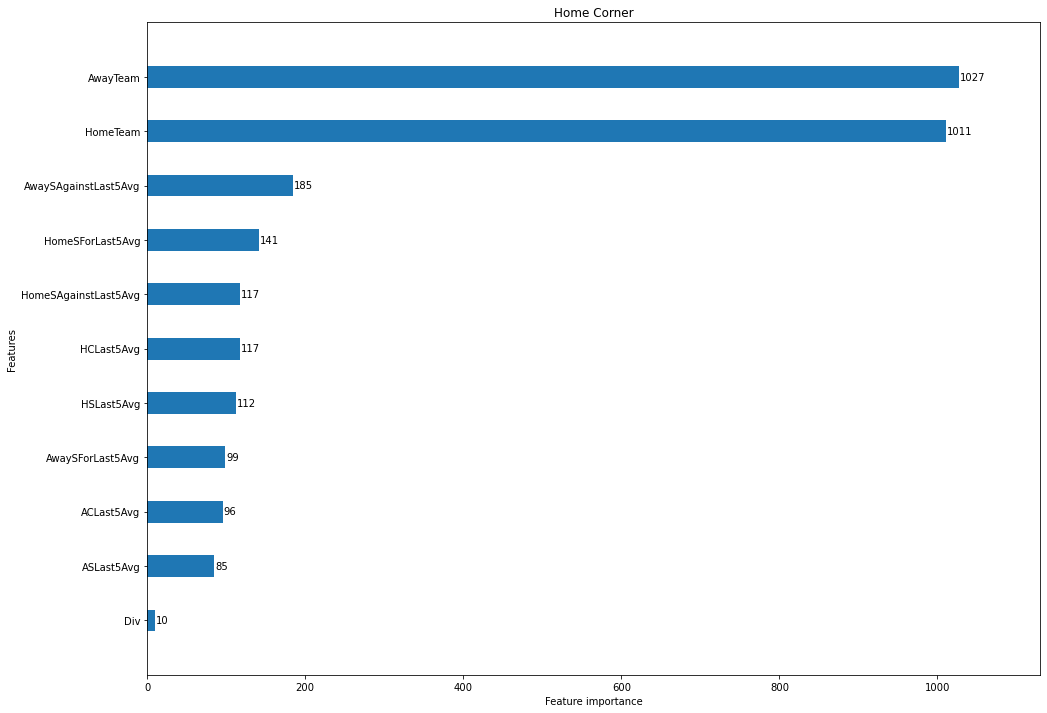

In [28]:
lgbm.plot_importance(m_lgbm.estimators_[0], figsize=(16, 12), title='Home Corner', max_num_features=40, height=0.4, grid=False);

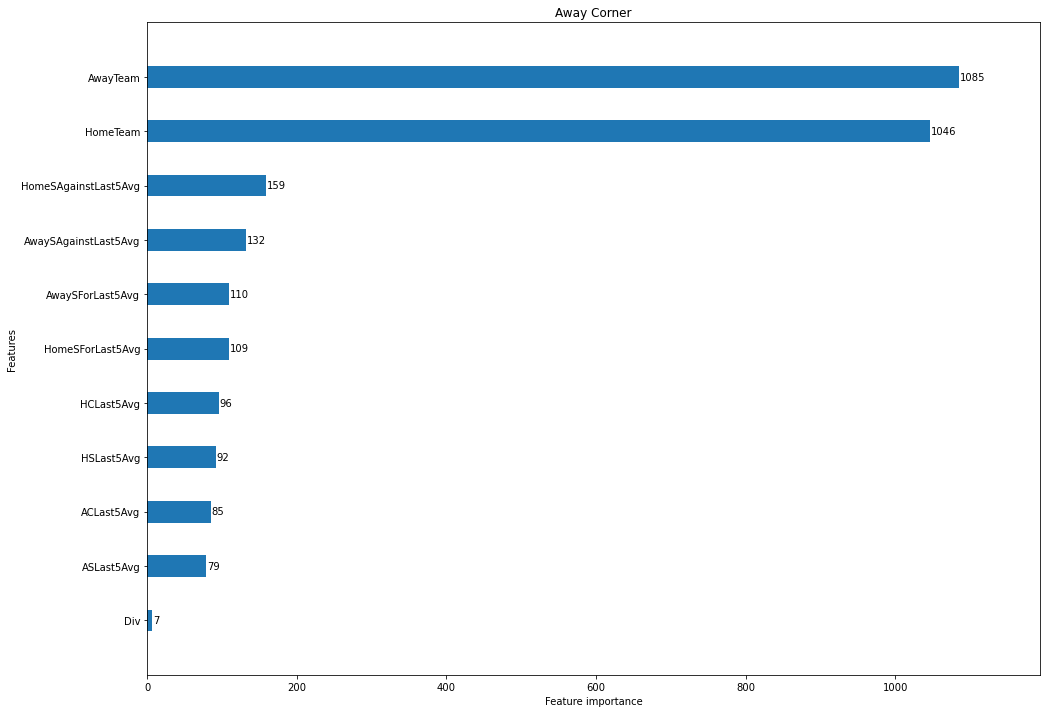

In [29]:
lgbm.plot_importance(m_lgbm.estimators_[1], figsize=(16, 12), title='Away Corner', max_num_features=40, height=0.4, grid=False);

## XGBoost

In [30]:
m_xgb = MultiOutputRegressor(XGBRegressor(objective='count:poisson', n_estimators=100, n_jobs=-1, tree_method='exact'))
m_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='count:poisson',
                                            rand

In [31]:
import xgboost as xgb

In [32]:
for i in range(0, 2):
    m_xgb.estimators_[i].get_booster().feature_names = list(X_test.columns)

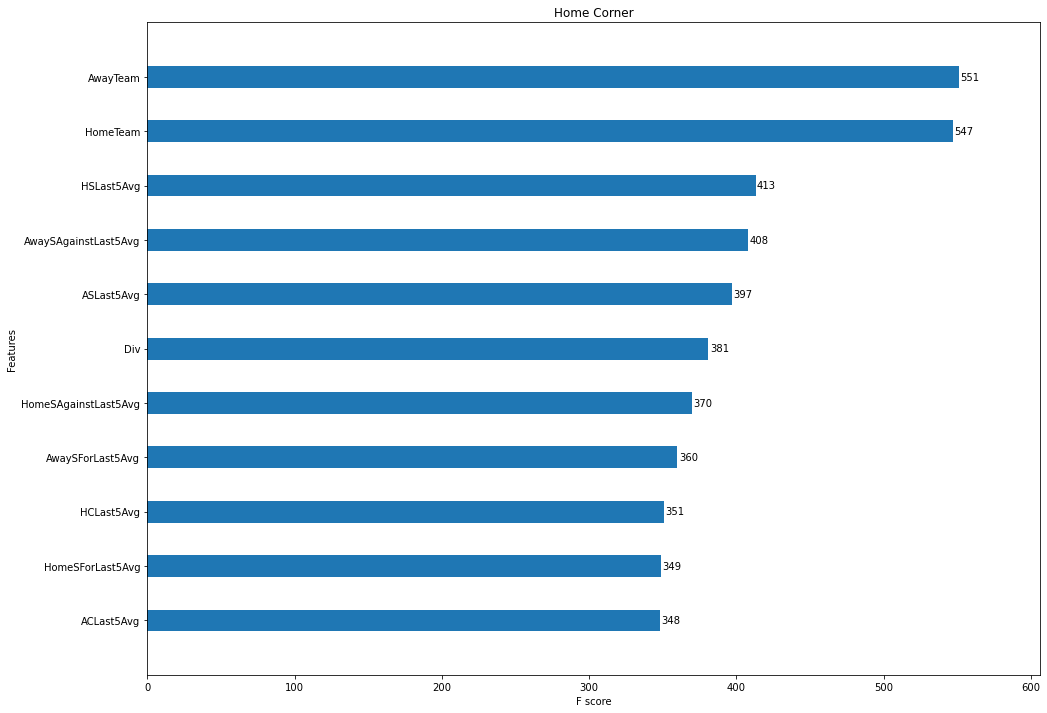

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[0], title='Home Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

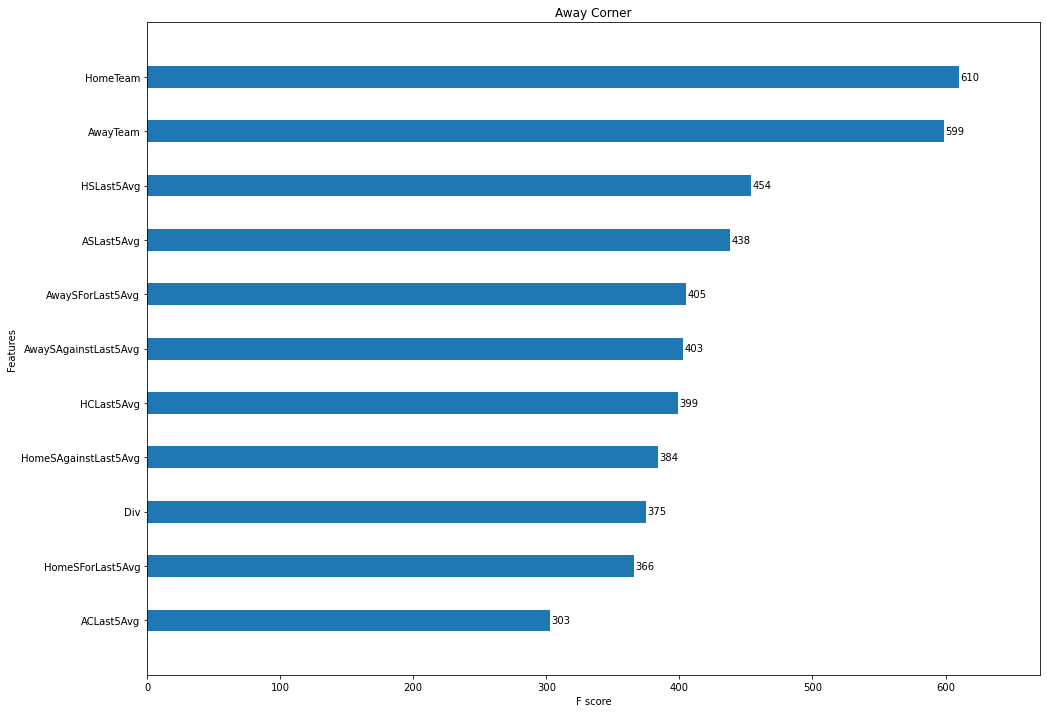

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[1], title='Away Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

## Poisson

In [35]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg,HC,AC
0,F1,Lille,Guingamp,13.6,2.8,11.2,5.4,13.8,12.2,10.000000,16.0,4.0,4.0
1,E0,Chelsea,Cardiff,21.0,6.8,12.6,5.6,16.4,13.2,10.200000,9.4,5.0,4.0
2,F1,Monaco,Marseille,14.6,6.4,14.0,4.8,12.4,10.0,13.400000,11.8,6.0,4.0
3,I1,Verona,Bologna,8.8,5.6,14.4,5.0,12.0,12.4,8.800000,14.8,4.0,4.0
4,F2,Paris FC,Nancy,9.2,5.8,5.8,5.2,9.2,8.6,9.800000,6.2,5.0,1.0
5,SP2,Almeria,Numancia,11.6,7.0,11.4,4.6,12.2,13.0,8.200000,8.0,7.0,3.0
6,E2,Wigan,Rochdale,8.6,4.0,10.4,4.4,6.0,12.0,16.600001,14.8,3.0,2.0
7,E1,Sheffield Weds,Birmingham,12.4,4.4,16.0,5.8,14.8,16.6,11.600000,12.2,12.0,1.0
8,I2,Pordenone,Brescia,11.8,7.0,11.0,4.6,9.8,14.2,15.600000,15.0,4.0,6.0
9,SP2,Albacete,Alcorcon,10.6,5.6,9.0,5.6,10.0,10.4,7.800000,8.6,4.0,1.0


In [36]:
learn = tabular_learner(dls, layers=[240, 120])

In [37]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(268, 37)
    (2): Embedding(268, 37)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=88, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=2, bias=True)
    )
  )
)

In [38]:
learn.loss_func = BaseLoss(partial(nn.PoissonNLLLoss, log_input=True, full=True), floatify=True)

SuggestedLRs(valley=0.005248074419796467)

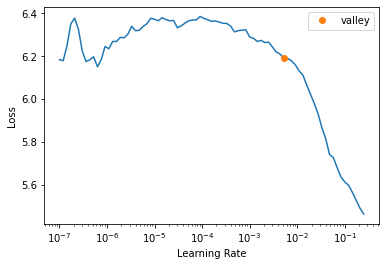

In [39]:
learn.lr_find()

In [40]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,2.764941,2.493193,00:02
1,2.418083,2.400786,00:01
2,2.382260,2.424611,00:02
3,2.330880,2.382171,00:02
4,2.263465,2.397247,00:03


In [41]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')[['HC', 'AC']]

,HC,AC
3457,3.0,11.0


In [42]:
_, _, params = learn.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                               .drop(columns=y_names).iloc[0])

In [43]:
pois_corner_home = torch.distributions.poisson.Poisson(params[0].exp())
pois_corner_away = torch.distributions.poisson.Poisson(params[1].exp())

In [44]:
print(pois_corner_home.mean, pois_corner_home.variance)
print(pois_corner_away.mean, pois_corner_away.variance)

tensor(3.7942) tensor(3.7942)
tensor(5.6395) tensor(5.6395)


In [45]:
corner_home = pois_corner_home.log_prob(torch.arange(0., 15.)).exp()
corner_away = pois_corner_away.log_prob(torch.arange(0., 15.)).exp()
corner = torch.ger(corner_home, corner_away)
mask = torch.zeros_like(corner)

In [46]:
mask = torch.zeros_like(corner)
line = 10.5
for i in range(0, mask.size()[0]):
    for j in range(0, mask.size()[1]):
        if i + j < line: mask[i, j] = 1. 

In [47]:
prob_lo = (corner * mask).sum()
prob_hi = 1 - prob_lo

In [48]:
prob_lo, prob_hi

(tensor(0.6535), tensor(0.3465))

## Negative Binomial

In [49]:
y_names = ['HC', 'AC', 'weight']
y_block = RegressionBlock(n_out=5)

In [50]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [51]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg,HC,AC,weight
0,F2,Grenoble,Sochaux,11.000000,5.6,9.8,4.0,9.8,9.6,12.0,12.8,6.0,4.0,1.154305
1,D1,Wolfsburg,Hoffenheim,15.600000,6.6,14.4,3.6,14.2,13.4,10.0,18.6,4.0,6.0,0.842341
2,F1,Nice,Toulouse,13.400000,5.4,10.4,4.0,9.2,13.0,13.6,11.0,2.0,6.0,0.758225
3,E2,Blackpool,Walsall,9.000000,5.4,10.4,4.6,6.8,9.4,8.8,9.4,1.0,8.0,0.744230
4,E2,Fleetwood Town,Doncaster,10.800000,6.0,9.0,2.8,11.8,9.0,13.0,12.4,8.0,5.0,1.110869
5,I1,Genoa,Chievo,11.400000,5.2,9.2,4.2,10.2,8.6,10.0,15.6,7.0,4.0,0.690785
6,SP2,Cadiz,Granada,12.400000,5.8,9.0,3.4,10.8,10.0,10.8,10.8,5.0,2.0,0.732497
7,I1,Empoli,Roma,11.400000,4.2,13.2,6.0,10.4,13.8,14.0,10.8,4.0,3.0,0.694581
8,F1,Lyon,Dijon,18.200001,7.4,9.4,4.6,18.4,9.2,11.0,16.4,8.0,3.0,0.767420
9,I1,Cagliari,Torino,9.200000,5.2,11.8,3.6,10.0,13.2,11.0,8.0,8.0,3.0,1.116972


In [52]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [53]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(268, 37)
    (2): Embedding(268, 37)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=88, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [54]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.011787540279328823)

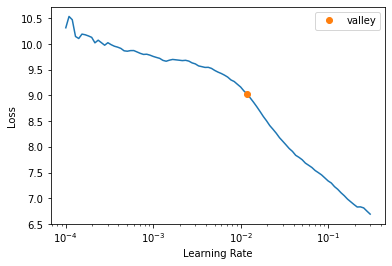

In [55]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [56]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,4.858746,6.437734,00:03
1,4.308874,6.156567,00:02
2,4.271378,6.149393,00:01
3,4.229334,6.120959,00:01
4,4.169039,6.147027,00:01


In [57]:
df.query('Season==21 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')[['HC', 'AC']]

,HC,AC
3499,4.0,13.0


In [58]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [59]:
_, params = learn_bnb.predict(df.query('Season==21 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')
                                .drop(columns=y_names).iloc[0])

In [60]:
params

tensor([ -1.6677,  -2.7137,   3.2460,   5.3859, -38.6199])

In [61]:
alpha = F.softplus(params[0:2])
mu = F.softplus(params[2:4])
omega = params[4]
# omega = torch.tanh(params[4]) * 50.

total_count = 1. / alpha
logits = torch.log(alpha * mu)

print(alpha, mu, omega)

tensor([0.1728, 0.0642]) tensor([3.2842, 5.3905]) tensor(-38.6199)


In [62]:
bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)

In [63]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([3.2842, 5.3905]) tensor([5.1484, 7.2555])


In [64]:
# Method 1:
corr = omega * torch.sqrt(mu.prod()) * alpha.prod() / ((1.+alpha)**(1./alpha+1.)).prod() / torch.sqrt((1.+alpha*mu).prod())
corr 

tensor(-0.1500)

In [65]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod()*(1.+alpha*mu).prod()) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod()
# corr 

In [66]:
value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [67]:
corner = bnb_corner.log_prob(value).exp()

In [68]:
line = 10.5
mask = value.sum(-1) < line
prob_lo = corner[mask].sum()
prob_hi = 1 - prob_lo

In [69]:
prob_lo, prob_hi

(tensor(0.7298), tensor(0.2702))

In [70]:
1/prob_lo, 1/prob_hi

(tensor(1.3703), tensor(3.7008))

### Train full model

In [71]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block)

In [72]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg,HC,AC,weight
0,I1,Atalanta,Torino,16.6,4.8,7.6,4.2,13.4,9.200000,11.6,10.600000,11.0,1.0,0.690785
1,SP1,Barcelona,Huesca,14.8,6.2,11.2,5.6,13.6,12.000000,5.8,13.400000,7.0,3.0,1.131758
2,SP1,Elche,Valencia,7.6,3.0,10.6,6.2,6.8,7.800000,14.8,16.799999,0.0,7.0,1.046463
3,D2,Hamburg,Greuther Furth,14.4,6.0,11.6,4.6,10.6,12.800000,11.2,9.000000,9.0,5.0,1.113306
4,I1,Cagliari,Genoa,10.8,6.8,7.6,3.6,7.6,10.000000,11.2,10.400000,4.0,3.0,0.840958
5,I2,Crotone,Vicenza,12.4,7.0,13.8,4.6,13.4,13.200000,12.8,11.200000,9.0,2.0,1.302189
6,I2,Pisa,Ternana,11.8,3.6,12.6,4.6,10.8,16.799999,13.4,12.200000,8.0,6.0,1.359050
7,F1,Angers,Rennes,10.4,3.8,10.6,4.2,11.6,11.800000,9.4,10.800000,4.0,2.0,0.767420
8,I1,Verona,Parma,9.8,4.8,7.4,3.6,9.0,10.200000,13.2,14.400000,4.0,4.0,1.114527
9,D1,Hertha,Hoffenheim,10.0,3.6,10.8,3.8,11.8,13.400000,12.6,14.000000,4.0,4.0,0.857711


In [73]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [74]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(268, 37)
    (2): Embedding(268, 37)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=88, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [75]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.011787540279328823)

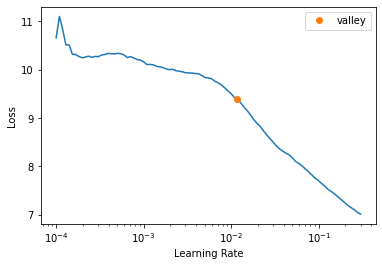

In [76]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [77]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,4.870742,None,00:02
1,4.694280,None,00:02
2,4.693578,None,00:03
3,4.605825,None,00:02
4,4.583704,None,00:02


/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [78]:
learn_bnb.export('models/learn_bnbsl.pkl')

In [79]:
to.export('models/to.pkl')

### t-SNE

In [80]:
df['HomeTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves',
       'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens',
       'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento',
       'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos',
       'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge',
       'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'D

In [81]:
df['AwayTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves',
       'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens',
       'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento',
       'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos',
       'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge',
       'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'D

In [82]:
variable = 'HomeTeam'
ix = cat_names.index(variable)

var_vals = list(df[variable].astype('category').cat.categories.values)
nval = len(var_vals)
print(f'Number of values: {nval}')
print(var_vals)

Number of values: 267
['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves', 'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens', 'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa', 'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre', 'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento', 'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn', 'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux', 'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos', 'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge', 'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly', 'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo', 'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry', 'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt', 'Derby', 'Dijon', 'Doncaster', 'Dortmund', 'Dresden', 'Duisburg', 'Dunkerque', 'Eibar', 'Ein Frankfurt

In [83]:
# import altair as alt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

emb_mx = to_np(next(learn_bnb.model.embeds[ix].parameters()))
#X_emb = TSNE(n_components=2, perplexity=3).fit_transform(emb_mx)
#X_emb = PCA(n_components=2).fit_transform(emb_mx)
annotation = np.append('Other', np.array(var_vals))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' 

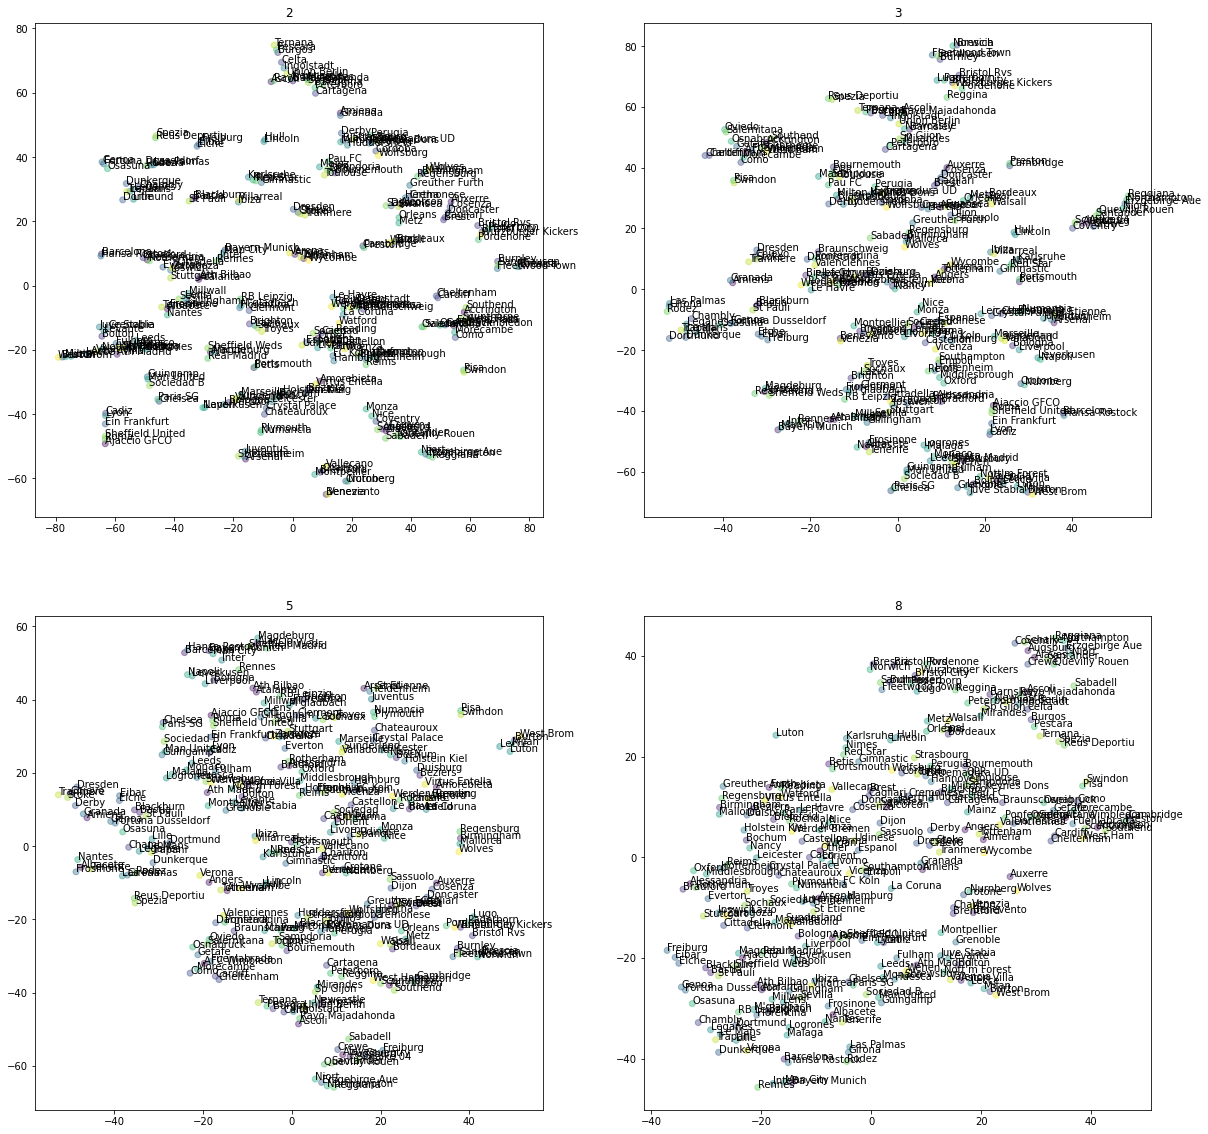

In [84]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(20)

perplexity = [2, 3, 5, 8]
for ax,perp in zip(axes.flatten(), perplexity):
    X_emb = TSNE(n_components=2, perplexity=perp).fit_transform(emb_mx)
    ax.scatter(X_emb[:,0], X_emb[:,1], c=range(len(annotation)), alpha=0.4)
    for xy,target in zip(X_emb, annotation):
        if isinstance(target, np.str_) or isinstance(target, str):
            text = target
        else:
            text = "%d" % target
        ax.annotate(text=text, xy=(xy[0], xy[1]))
        ax.set_title(perp)

# END